# Submitted by: Hans Xavier W. Wong 
No other external resources were consulted other than the documentation for the installed package to check functions like the adfuller test and the pd.Group method.

# Trends and Patterns

There will be cases where you will be working with data that has some datetime feature. In most cases, understanding the trends and patterns of these data points over time may be useful in the analysis.

### What is a time series?
Time series data are samples observed in a chronological matter (across time), usually sampled at regular intervals. Some example applications in different fields are:

    1. Economics - This field usually look at the indicators of a country over time to see if the country is improving. Examples: GDP, unemployment, inflation, CPI, poverty.
    2. Finance - Daytraders that focus on technical analysis are actually looking at time series of the different stock prices to monitor trends and patterns to inform their decisions.
    3. Physics - Sine and cosine waves are heavily used in understanding sound and spread of soundwavse across time.

####  Some Samples

`DJIA 30 Stock Time Series` - Average stock price of specific companies included in the Dow Jones Index (used to assess market health).

![Stocks](https://miro.medium.com/max/1400/0*bCS3EWiVfLIZqwIW.gif)

`Voice sampled every .2 seconds` - Average frequency and amplitude of voice sampled at specific timeframes. Time series representation of voices are actually used to model voice recognition algorithms.


![Voice](https://miro.medium.com/max/700/1*80fnKgU_07EzqXWkJXZrQQ.png)

`Inflation Across Time Among the ASEAN Countries` - This shows the trend of inflation of different countries across time. Kinda shows how bad it is here in the PH as compared to other countries
![Inflation](https://assets.rappler.co/4A0970D12C774D96850FBCDB5D2707AA/img/86CDAB18C8304B6CB5DACBF8CA471CBC/Fig_1_aseaninf.png)



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.style.use('ggplot')

## Identifying Outliers or Events

With time series data, there are certain cases wherein a sudden spike would happen. It could be erroneous data, or it could be a valid data point where an event occured. 

Let's take this dataset from the FDNY ([provided by the NYC Open Data Portal](https://data.cityofnewyork.us/Public-Safety/FDNY-Line-Of-Duty-Deaths/32y8-s55c)) as an example.

In [3]:
fdny = pd.read_csv('data/FDNY_Line_Of_Duty_Deaths.csv')
fdny.head()

,Rank,Name,Unit,Date
0,FIREFIGHTER,ROBERT WINTRINGHAM,ENGINE 1,"AUGUST 24, 1865"
1,FIREFIGHTER,GEORGE BELL,ENGINE 8,"NOVEMBER 8, 1865"
2,FIREFIGHTER,THOMAS IRVIN,ENGINE 4,"DECEMBER 2, 1865"
3,FIREFIGHTER,DOMINICK SICOT,ENGINE 4,"DECEMBER 14, 1865"
4,FIREFIGHTER,PETER H. WALSH,ENGINE 5,"MAY 21, 1866"


First thing's first, looking at the datatypes, we can see that the `Date` column is not yet set to a `datetime` object. How do you convert that?

In [4]:
# your code here
fdny['datetime'] = pd.to_datetime(fdny['Date'])

In [5]:
fdny.head()

,Rank,Name,Unit,Date,datetime
0,FIREFIGHTER,ROBERT WINTRINGHAM,ENGINE 1,"AUGUST 24, 1865",1865-08-24
1,FIREFIGHTER,GEORGE BELL,ENGINE 8,"NOVEMBER 8, 1865",1865-11-08
2,FIREFIGHTER,THOMAS IRVIN,ENGINE 4,"DECEMBER 2, 1865",1865-12-02
3,FIREFIGHTER,DOMINICK SICOT,ENGINE 4,"DECEMBER 14, 1865",1865-12-14
4,FIREFIGHTER,PETER H. WALSH,ENGINE 5,"MAY 21, 1866",1866-05-21


Right now, this dataset is not yet a time series since we have the death records for each. For this to become a time series, we would need a quantitative variable for each `datetime`.

The simplest way is to get the `value_counts()` and that should provide us with a series.

In [6]:
fdny_death_series = pd.DataFrame(fdny['datetime'].value_counts())
fdny_death_series.columns = ['deaths']
fdny_death_series.sample(10)

,deaths
1962-01-17,1
1918-01-04,1
1890-10-28,1
1970-05-17,1
1943-03-22,1
1979-03-19,1
1901-02-21,1
1945-10-17,1
1973-06-02,1
1929-11-27,1


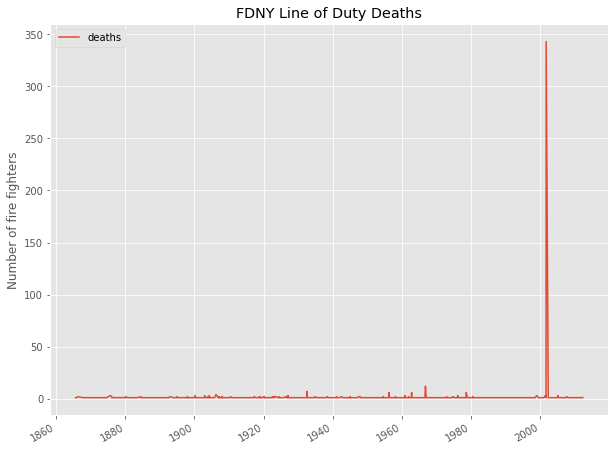

In [7]:
ax = fdny_death_series.plot(figsize=(10,8))
ax.set_title('FDNY Line of Duty Deaths')
ax.set_ylabel('Number of fire fighters');

#### What can you see from this plot?

Based on the graph, there was a rapid spike in firefighter deaths shortly after the year 2000, most likely during 09/11. This deviance of up to 350 deaths is extremely large compared to the 0-20ish range seen in all the other years.

In [8]:
fdny_death_series.describe()

,deaths
count,733.000000
mean,1.594816
std,12.643961
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,343.000000


Given that we have a large standard deviation, we can see that the maximum value is skewing our entire dataset. If we remove the datapoint, we can potentially see more detail in our series.

In [9]:
fdny_death_series.mean()

deaths    1.594816
dtype: float64

#### Thresholding

A quick and easy way to find outliers in a time series would be to use the thresholding method. 

By simply using the mean and standard deviation of the series, we can get an upper and lower threshold if necessary.

Since the lower threshold for this dataset would be negative, it doesn't seem to make sense to compute for it now.

In [10]:
upper_threshold = float(fdny_death_series.mean() + (3 * fdny_death_series.std())) # upper threshold seems to be computed by mean + 3*STD 
print(upper_threshold)

39.52669938756396


In [11]:
fdny_death_series[fdny_death_series['deaths'] >= upper_threshold]

,deaths
2001-09-11,343


Looking at this date, we can more or less conclude that the 9/11 bombing was the major event that caused quite a number of deaths in the FDNY. 

By removing the data point temporarily in a copy of the dataframe, we can inspect further the dataset to see if there are any more "outliers" or special events.

In [12]:
fdny_death_copy = fdny_death_series.copy()
fdny_death_copy.loc['2001-09-11'] = np.NaN # why make this point null instead of just dropping the row? 

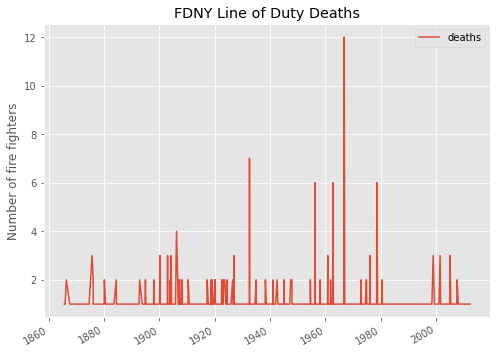

In [13]:
ax = fdny_death_copy.plot(figsize=(8,6))
ax.set_title('FDNY Line of Duty Deaths')
ax.set_ylabel('Number of fire fighters');

In [14]:
upper_threshold = float(fdny_death_copy.mean() + (3 * fdny_death_copy.std()))
print(upper_threshold)

3.075513409918649


In [15]:
fdny_death_copy[fdny_death_copy['deaths'] >= upper_threshold]

,deaths
1966-10-17,12.0
1932-08-01,7.0
1962-10-26,6.0
1978-08-02,6.0
1956-04-04,6.0
1906-03-26,4.0


Looking at the data here, we can see that there's not much outliers but depending on your definition, you can further trim down the outliers based on your thresholds.

## Aggregation and Granularity

Granularity in panel data talks about the level of grouping of the samples. Usually we group them to be able to analyze samples a larger scale. Similarly, we can also group time series data depending on the level of **temporality** that you would want to check. The usual level of grouping for time is : 

`Seconds` -> `Minutes` -> `Hours` -> `Days` -> `Weeks` -> `Months` -> `Years` -> `Decades` -> `Centuries`

Example: 

![Stocks](http://kourentzes.com/forecasting/wp-content/uploads/2014/05/fors1.fig1_.png)

In [16]:
ny_aqi = pd.read_csv('data/ny_aqi_daily_1980_to_2021.csv')
ny_aqi['Date'] = pd.to_datetime(ny_aqi['Date'])
ny_aqi.head()

,State Name,Date,AQI,Category,Defining Parameter,Latitude,Longitude,County Name
0,New York,2021-01-01,36,Good,PM2.5,42.640931,-73.756511,Albany
1,New York,2021-01-02,28,Good,Ozone,42.640931,-73.756511,Albany
2,New York,2021-01-03,38,Good,PM2.5,42.640931,-73.756511,Albany
3,New York,2021-01-04,56,Moderate,PM2.5,42.640931,-73.756511,Albany
4,New York,2021-01-05,39,Good,PM2.5,42.640931,-73.756511,Albany


In [17]:
daily_agg = ny_aqi.groupby(pd.Grouper(key='Date', freq='D'))['AQI'].mean().reset_index()
weekly_agg = ny_aqi.groupby(pd.Grouper(key='Date', freq='W'))['AQI'].mean().reset_index()
monthstart_agg = ny_aqi.groupby(pd.Grouper(key='Date', freq='MS'))['AQI'].mean().reset_index()
monthend_agg = ny_aqi.groupby(pd.Grouper(key='Date', freq='M'))['AQI'].mean().reset_index()

# seems like the aggregations the `pd.Grouper` argument with the arguments key, and freq, subsetting the AQI score and saving the output as a main dataset 

In [18]:
daily_agg.head()

,Date,AQI
0,1980-01-01,80.588235
1,1980-01-02,72.882353
2,1980-01-03,49.058824
3,1980-01-04,66.588235
4,1980-01-05,46.823529


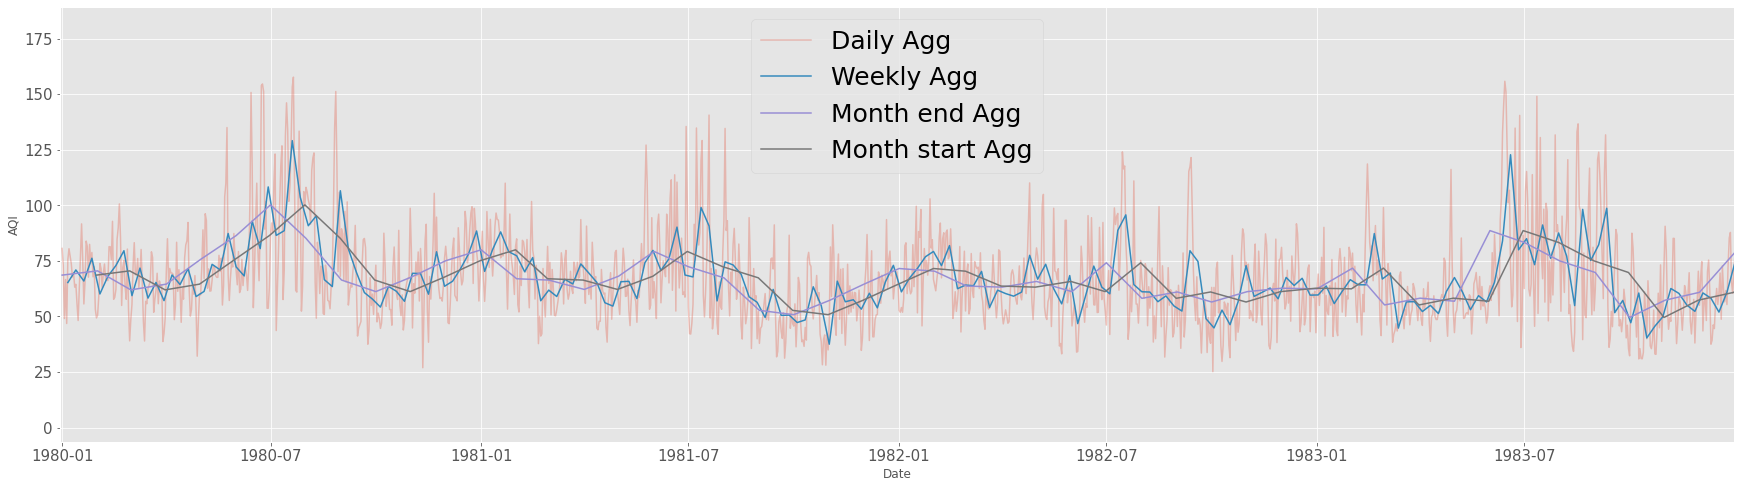

In [19]:
plt.figure(figsize=(30,8))

#Plotting the Grouped Data with different Granularity
plt.plot(daily_agg['Date'], daily_agg['AQI'], label='Daily Agg', alpha=0.3) # setting the different graphs using plt methods 
plt.plot(weekly_agg['Date'], weekly_agg['AQI'], label='Weekly Agg',)
plt.plot(monthstart_agg['Date'], monthstart_agg['AQI'], label='Month end Agg')
plt.plot(monthend_agg['Date'], monthend_agg['AQI'], label = 'Month start Agg')

# using legends, ticks, and labels to improve readability
plt.legend(fontsize=25) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim([pd.to_datetime('1979-12-30'), pd.to_datetime('1983-12-31')]) # setting a daterange to limit the span 
plt.xlabel('Date')
plt.ylabel('AQI');

## Aggregation via a Moving Window
Notice that as we increase the granularity of the grouping, we were able to "smoothen" the graph. This is because time series aggregation will account for the the variation observed in the granular data (similar to when we group samples to specific categories to get descriptive statistics). 

One flaw in the usual aggregation method is it only accounts for the data at the specific window that we are aggregating (i.e. if we aggregate by month, the calculation will not factor in the previous months). It is in the nature of timeseries that datapoints are **autocorrelated** meaning the past is somehow related with the present values. This means that whatever the past values are in the series, it may have meaningful relationship with the present values that we **SHOULD** account for. Moving or Rolling averages were created to be able to account for this "flaw" in the usual timeseries aggregation method. 

Procedurally, this is what happens under the hood : 

![Moving average info](https://media.geeksforgeeks.org/wp-content/uploads/20211116101813/Capture.PNG)

We can implement it in python using the code block below: 

In [20]:
daily_agg['7D_MA'] = daily_agg['AQI'].rolling(window=7).mean() # the window argument likely refers to the number of days in the daily agg, if it's months, the number of months
daily_agg['7D_STD'] = daily_agg['AQI'].rolling(window=7).std()

In [21]:
daily_agg.head(14)

,Date,AQI,7D_MA,7D_STD
0,1980-01-01,80.588235,NaN,NaN
1,1980-01-02,72.882353,NaN,NaN
2,1980-01-03,49.058824,NaN,NaN
3,1980-01-04,66.588235,NaN,NaN
4,1980-01-05,46.823529,NaN,NaN
5,1980-01-06,75.470588,NaN,NaN
6,1980-01-07,80.444444,67.408030,14.140521
7,1980-01-08,77.166667,66.919234,13.659959
8,1980-01-09,73.764706,67.045285,13.728057
9,1980-01-10,67.722222,69.711485,11.239383


#### Benefits and downside of using Moving Averages

Benefits:
* Information from the Past - this method accounts for the possible relationship of past values with the present
* Smoothness - allows for the series to be smoothened making trend more visible (higher window, the smoother the series will be)
* Can be used for forecasting - one of the most intuitive and classical model
    
Downside:
* Loss of data

#### Challenge: Try getting the 30-day moving average of the NY AQI

In [22]:
# your code here
daily_agg['30D_MA'] = daily_agg['AQI'].rolling(window=30).mean()

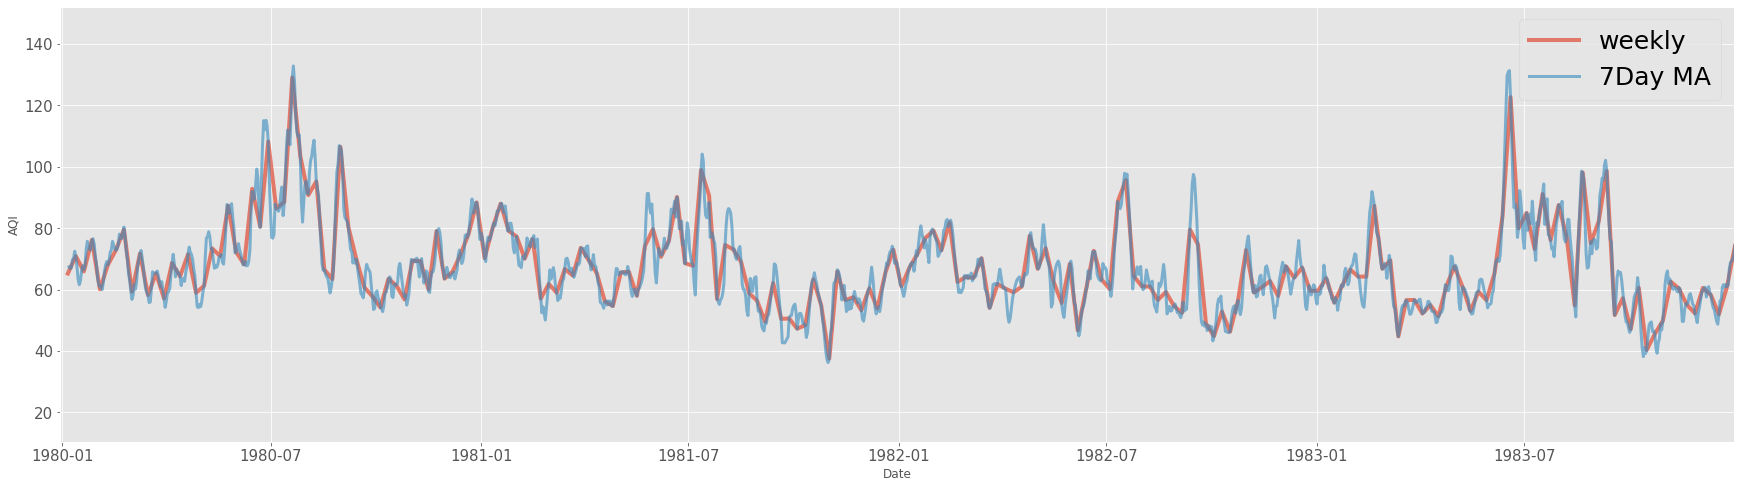

In [23]:
# Smoothness
plt.figure(figsize=(30,8))

plt.plot(weekly_agg['Date'], weekly_agg['AQI'], label='weekly', alpha=0.7, lw=4)

#Plotting the 7Day MA
plt.plot(daily_agg['Date'], daily_agg['7D_MA'], label='7Day MA', alpha=0.6, lw=3)

#Plotting the 30Day MA
# uncomment the line to show the 30 day
# plt.plot(daily_agg['Date'], daily_agg['30D_MA'], label='7Day MA', alpha=0.6, lw=3)

plt.legend(fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim([pd.to_datetime('1979-12-30'), pd.to_datetime('1983-12-31')])
plt.xlabel('Date')
plt.ylabel('AQI');

## Major Components of Observed Time Series

Time series have components that we can look at to further understand the behavior of our data.

`Trend` - long term slope and direction of the timeseries. Question : How long is long? and what if there are shifts in trend?

`Cycle` - pattern in data that is observed but is not chunked within a specific timeframe (i.e. repeat during x number of weeks/days, but boom and bust is observable)

`Seasonality` - calendar based effects (seasons, definite scheduled holidays, tax periods)

`Irregularity` - term to capture stochasticity and randomness.


### Extracting the Major Components of a Series

Decomposition is a technique that can help us make sense of a time series. The result of decomposition will allow us to know what kind of "preprocessing" technique to apply to the series before we can move forward with more complex analysis and modelling.

The two most common ways to decompose a series are : 

    Additive Model - states that the series can be created by aggregating the estimated componantes together

    Multiplicative Model - states that the series can be created by multiplying the estimated componantes together

The code below will allow us to extract the important components of a timeseries

In [24]:
decompose_sample = ny_aqi.copy()

decompose_sample = decompose_sample.groupby(pd.Grouper(key='Date', freq='MS'))['AQI'].mean().reset_index() # grouping by MS frequency

decompose_sample = decompose_sample.set_index(pd.to_datetime(decompose_sample['Date'])).dropna() # setting and dropping all null dates

decompose_sample.sort_index(inplace=True)

In [25]:
decompose_sample['Year'] = decompose_sample['Date'].dt.year # extracting the year and month from the dt objects
decompose_sample['Month'] = decompose_sample['Date'].dt.month

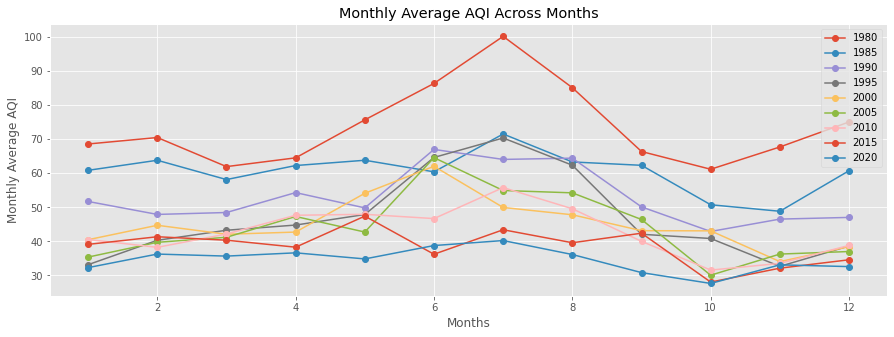

In [26]:
# Analyze first the original series 
# What is the trend? What months, on average is high? it appears that the months of June (6), July (7), are higher
# What to expect when we extract the components? 
plt.figure(figsize=(15, 5))
for each in decompose_sample['Year'].unique()[0::5]:
    plt.plot(decompose_sample[decompose_sample['Year'] == each]['Month'],
             decompose_sample[decompose_sample['Year'] == each]['AQI'], marker='o', label=each)
    
    plt.legend(loc='best')
    plt.xlabel('Months')
    plt.ylabel('Monthly Average AQI')
    plt.title('Monthly Average AQI Across Months')

In [27]:
decompose_sample.head()

,Date,AQI,Year,Month
Date,,,,
1980-01-01,1980-01-01,68.582255,1980,1
1980-02-01,1980-02-01,70.484009,1980,2
1980-03-01,1980-03-01,61.944656,1980,3
1980-04-01,1980-04-01,64.520080,1980,4
1980-05-01,1980-05-01,75.667954,1980,5


In [28]:
result = seasonal_decompose(decompose_sample['AQI'], model='additive') # setting the model as additive, and creating an object to be called 

Text(0.5, 1.0, 'Residuals')

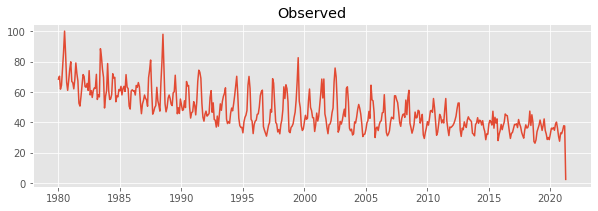

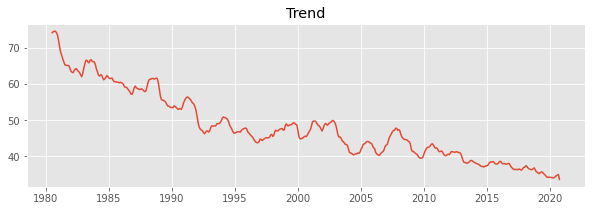

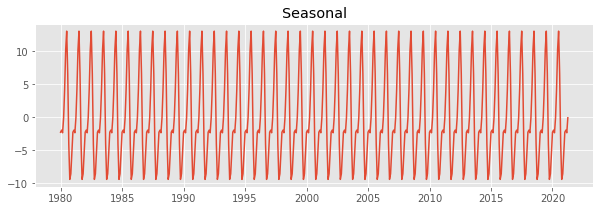

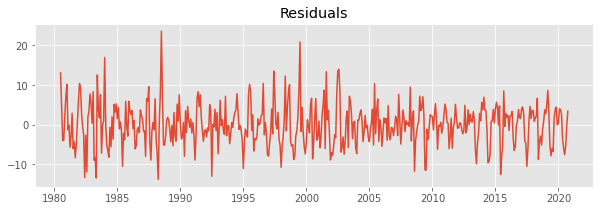

In [29]:
plt.figure(figsize=(10,3))
plt.plot(result.observed) # extracting observed results 
plt.title("Observed")

plt.figure(figsize=(10,3))
plt.plot(result.trend)
plt.title("Trend")

plt.figure(figsize=(10,3))
plt.plot(result.seasonal) # extracting seasonal 
plt.title("Seasonal")

plt.figure(figsize=(10,3))
plt.plot(result.resid) # extracting residuals
plt.title("Residuals") 

### Monthly expectation

By analyzing the seasonality index extracted, we can somehow see the effect of certain months on the closing stock price. The graph below will give us an idea if a certain month has a positive / negative effect on the average closing price for that specific month.

In [30]:
seasonality_value = result.seasonal.reset_index()

In [31]:
seasonality_value['Month'] = seasonality_value['Date'].dt.month
seasonality_value = seasonality_value[['seasonal', 'Month']].drop_duplicates()

Here we can see that Microsoft's stock prices drop (on average) during January, March, April, May, October, November and December.

In [32]:
seasonality_value

,seasonal,Month
0,-2.257141,1
1,-1.940027,2
2,-2.339527,3
3,-0.061777,4
4,4.217691,5
5,10.260936,6
6,13.080953,7
7,6.629030,8
8,-4.048291,9
9,-9.412191,10


<BarContainer object of 8 artists>

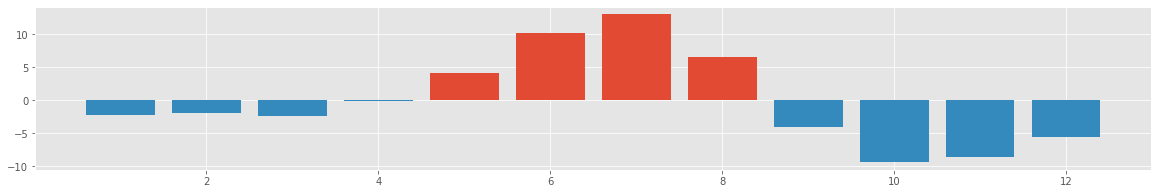

In [33]:
plt.figure(figsize=(20,3))

plt.bar(seasonality_value[seasonality_value['seasonal'] > 0]['Month'],
        seasonality_value[seasonality_value['seasonal'] > 0]['seasonal'])


plt.bar(seasonality_value[seasonality_value['seasonal'] <= 0]['Month'],
        seasonality_value[seasonality_value['seasonal'] <= 0]['seasonal'])

## Preprocessing Techniques Depend on Seasonality and Trend

The result that we get from decomposition will dictate what kind of preprocessing technique should be applied to the data. If you find that the data has seasonality / trend, we can use the table below to know how to impute for missing values. 

| Season      | Trend |Trendless |
| ----------- | ----------- |----------- |
| Seasonal      |Use __MEAN__ of the __adjacent__ years (same period)|Use __MEAN__ of __all__ available data |
| Non-Seasonal   |Use __MEAN__ of the __adjacent__ datapoints|Use __MEAN__ of __all__ available data  |


By following this table, we can more or less generate more accurate models.


## Stationarity and Autocorrelation


Some algorithms require stationarity of a series before it can be modelled. Non-stationary data, when used to train classical models (i.e. ARIMA) will result to autocorrelated residuals implying that the errors are severly increasing across time. This just means that the past values are dependent or **CORRELATED** with present and future values.  Residuals (Prediction - Actuals) that are not serially correlated is an assumption that must be passed before we can interpret ARIMA and other classical models. There are different preprocessing techniques that you can use to remove this relationship from the series.

A series that is stationary is defined to have the following properties :

    1) Trendless
    2) No predifined seasonality
    
    
![Stationarity](https://0megap0int.files.wordpress.com/2021/07/stationary.png)
  

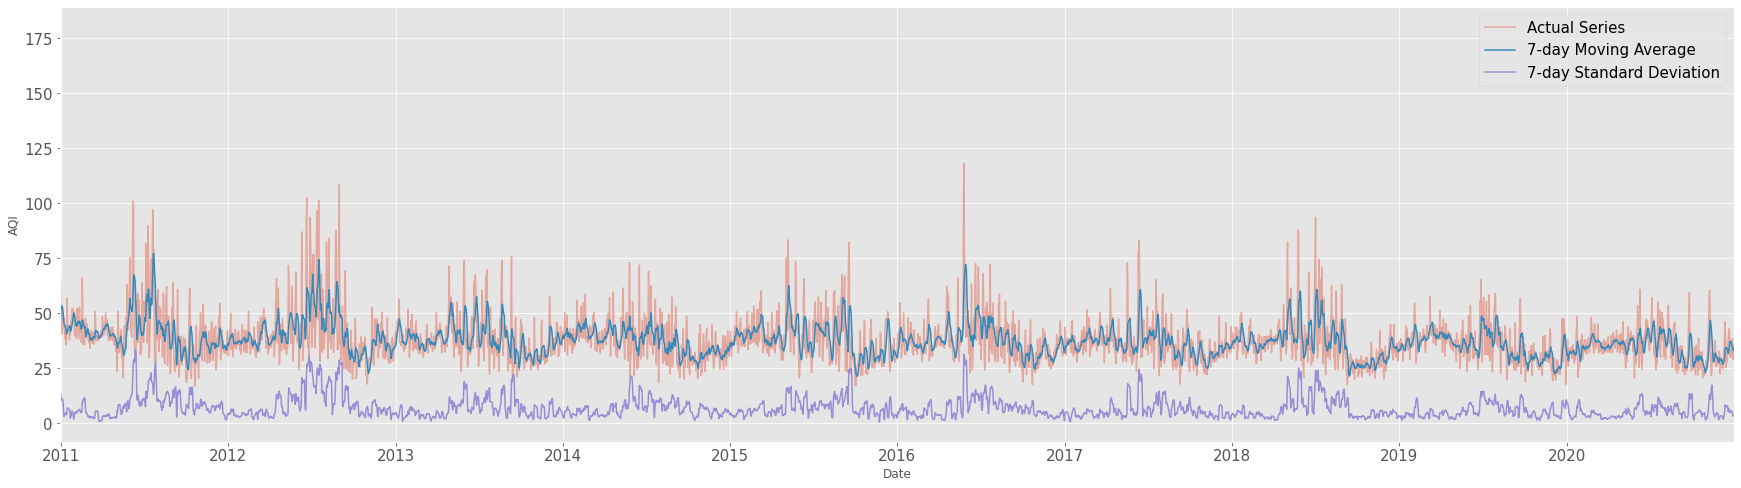

In [34]:
# Plotting Data
plt.figure(figsize=(30,8))

plt.plot(daily_agg['Date'], daily_agg['AQI'], label='Actual Series', alpha=0.4)
plt.plot(daily_agg['Date'], daily_agg['7D_MA'], label='7-day Moving Average')
plt.plot(daily_agg['Date'], daily_agg['7D_STD'], label='7-day Standard Deviation')


plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim([pd.to_datetime('2010-12-30'), pd.to_datetime('2020-12-31')])
plt.xlabel('Date')
plt.ylabel('AQI');

In [35]:
daily_agg['30D_MA'] = daily_agg['AQI'].rolling(window=30).mean()
daily_agg['30D_STD'] = daily_agg['AQI'].rolling(window=30).std()

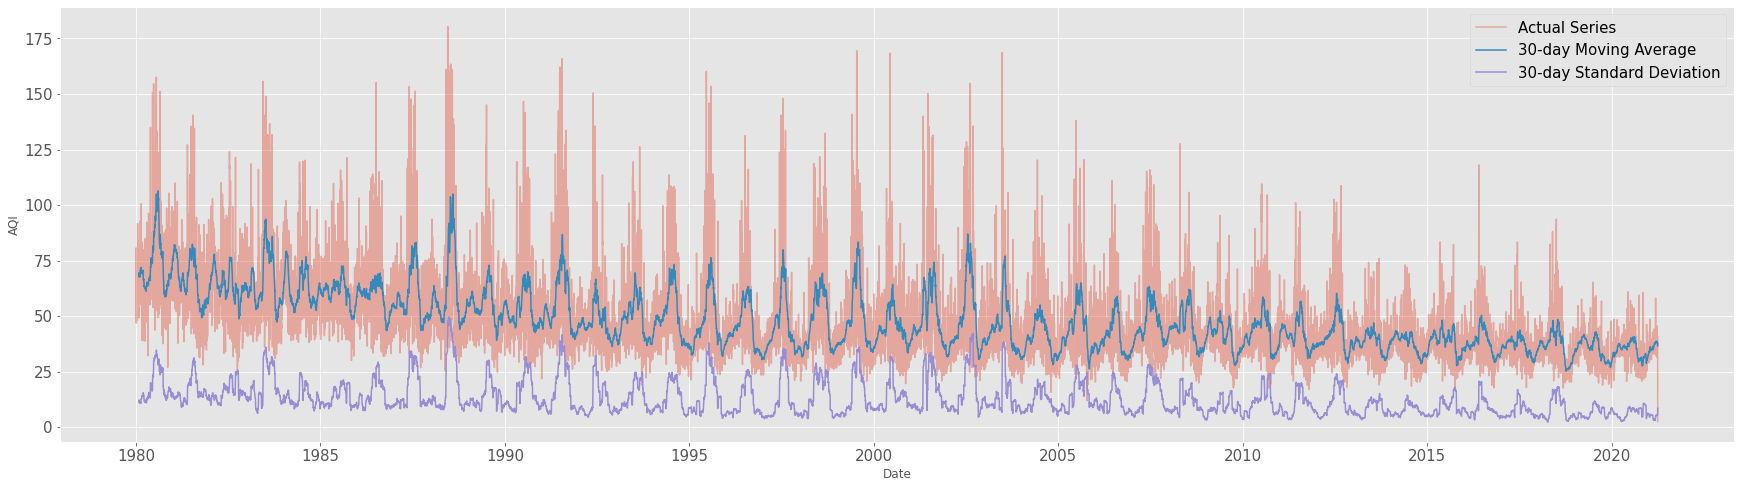

In [36]:
# Plotting Data
plt.figure(figsize=(30,8))

plt.plot(daily_agg['Date'], daily_agg['AQI'], label='Actual Series', alpha=0.4)
plt.plot(daily_agg['Date'], daily_agg['30D_MA'], label='30-day Moving Average')
plt.plot(daily_agg['Date'], daily_agg['30D_STD'], label='30-day Standard Deviation')


plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.xlim([pd.to_datetime('2010-12-30'), pd.to_datetime('2020-12-31')])
plt.xlabel('Date')
plt.ylabel('AQI');

### Differencing

You can difference the input series to be able to remedy for non-stationarity. Differencing is the direct subtraction of adjacent datapoints of timeperiod selected.

In [37]:
daily_agg['Differenced First Order'] = daily_agg['AQI'].diff()

In [38]:
daily_agg.head(10)

,Date,AQI,7D_MA,7D_STD,30D_MA,30D_STD,Differenced First Order
0,1980-01-01,80.588235,NaN,NaN,NaN,NaN,NaN
1,1980-01-02,72.882353,NaN,NaN,NaN,NaN,-7.705882
2,1980-01-03,49.058824,NaN,NaN,NaN,NaN,-23.823529
3,1980-01-04,66.588235,NaN,NaN,NaN,NaN,17.529412
4,1980-01-05,46.823529,NaN,NaN,NaN,NaN,-19.764706
5,1980-01-06,75.470588,NaN,NaN,NaN,NaN,28.647059
6,1980-01-07,80.444444,67.408030,14.140521,NaN,NaN,4.973856
7,1980-01-08,77.166667,66.919234,13.659959,NaN,NaN,-3.277778
8,1980-01-09,73.764706,67.045285,13.728057,NaN,NaN,-3.401961
9,1980-01-10,67.722222,69.711485,11.239383,NaN,NaN,-6.042484


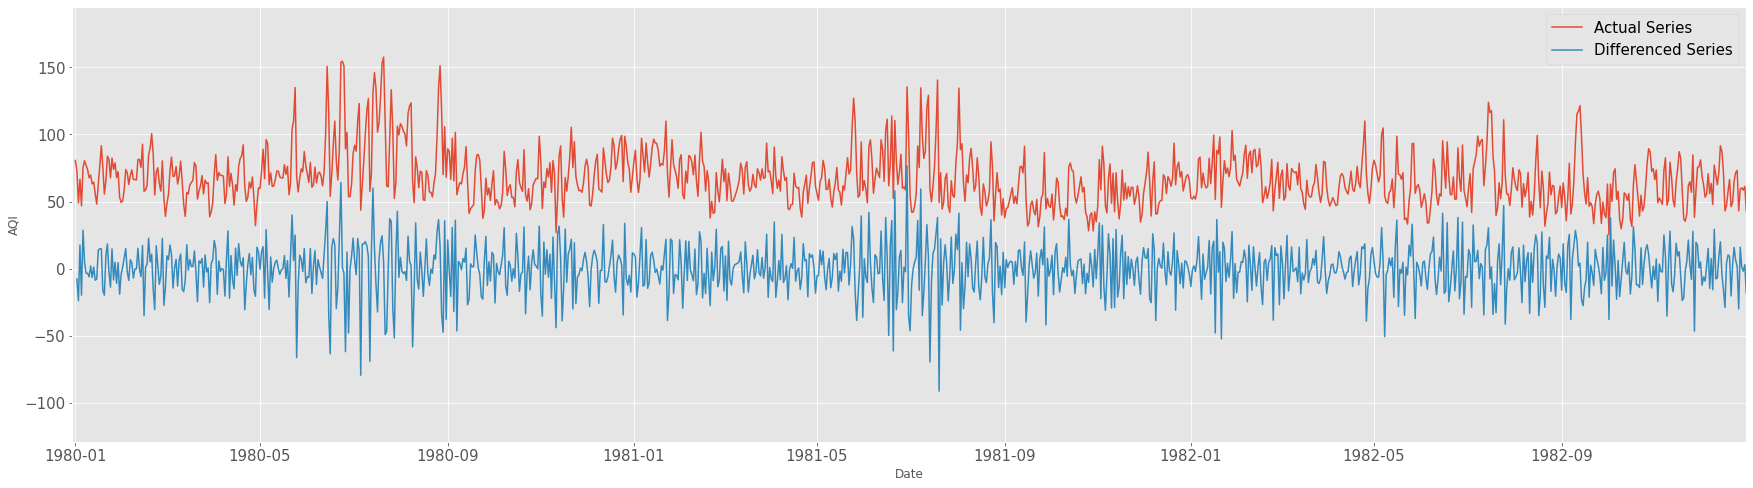

In [39]:
# Plotting Data
plt.figure(figsize=(30,8))

plt.plot(daily_agg['Date'], daily_agg['AQI'], label='Actual Series')
plt.plot(daily_agg['Date'], daily_agg['Differenced First Order'], label='Differenced Series')


plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim([pd.to_datetime('1979-12-30'), pd.to_datetime('1982-12-31')])
plt.xlabel('Date')
plt.ylabel('AQI');

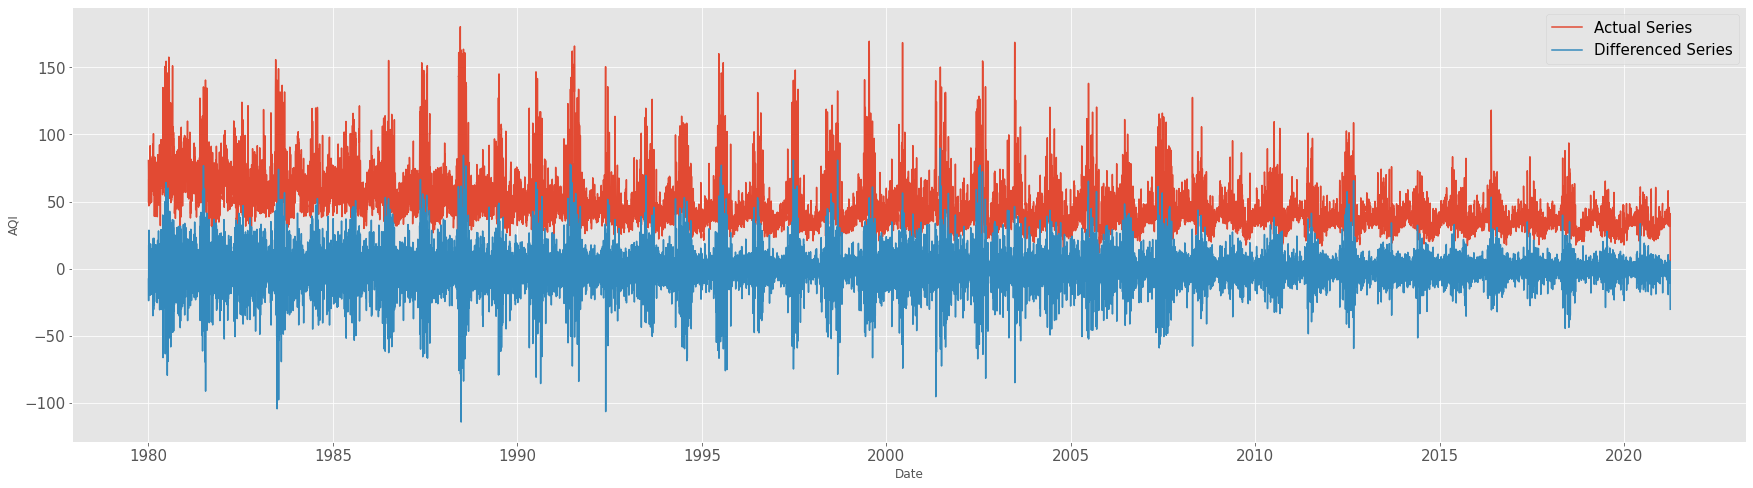

In [40]:
# Plotting Data
plt.figure(figsize=(30,8))

plt.plot(daily_agg['Date'], daily_agg['AQI'], label='Actual Series')
plt.plot(daily_agg['Date'], daily_agg['Differenced First Order'], label='Differenced Series')


plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.xlim([pd.to_datetime('1979-12-30'), pd.to_datetime('1982-12-31')])
plt.xlabel('Date')
plt.ylabel('AQI');

In [41]:
daily_agg['7D_Diff_MA'] = daily_agg['Differenced First Order'].rolling(window=7).mean()
daily_agg['7D_Diff_STD'] = daily_agg['Differenced First Order'].rolling(window=7).std()

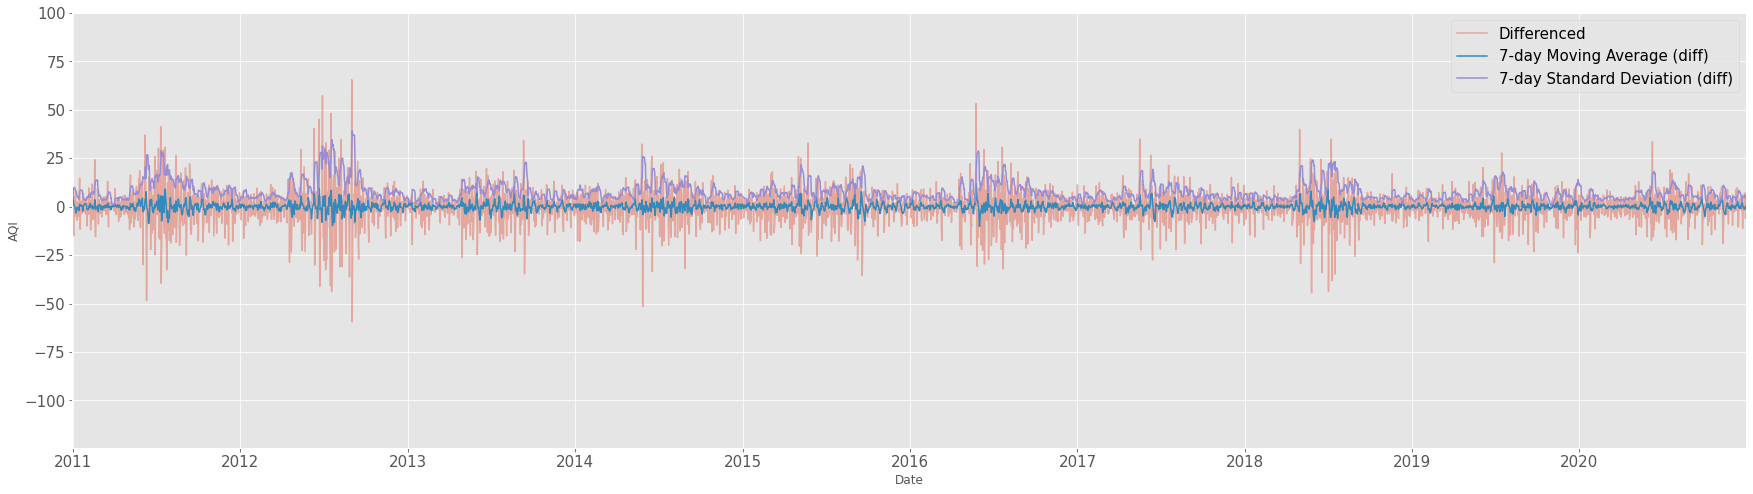

In [42]:
# Plotting Data
plt.figure(figsize=(30,8))

plt.plot(daily_agg['Date'], daily_agg['Differenced First Order'], label='Differenced', alpha=0.4)
plt.plot(daily_agg['Date'], daily_agg['7D_Diff_MA'], label='7-day Moving Average (diff)')
plt.plot(daily_agg['Date'], daily_agg['7D_Diff_STD'], label='7-day Standard Deviation (diff)')


plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim([pd.to_datetime('2010-12-30'), pd.to_datetime('2020-12-31')])
plt.xlabel('Date')
plt.ylabel('AQI');

### Augmented Dickey-Fuller test:

The formal way to check for stationarity is by using the [Augmented Dickey-Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_testhttps://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test).

Using the `statsmodels` function `adfuller` ([documentation](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html)), the hypothesis are as follows:

> The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root.
>
> The p-values are obtained through regression surface approximation from MacKinnon 1994, but using the updated 2010 tables. If the p-value is close to significant, then the critical values should be used to judge whether to reject the null.
>
> The autolag option and maxlag for it are described in Greene.

When we say "there is a unit root", this means that the series is **not stationary**. In other words, the time series has some time-dependent structure and does not have constant variance over time.

In [43]:
result = adfuller(daily_agg['AQI'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.389442
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [44]:
result = adfuller(daily_agg['Differenced First Order'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -25.699233
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


#### Conclusion
Since in both cases, the p-value is less than 0.05 (5% significance level), we can reject the null that the time series is **not stationary**. Therefore this time series is a stationary time series.

## Do it yourself!

Test it out on this dataset on airline passengers.

In [45]:
airline = pd.read_csv('data/airline-passengers.csv')
airline.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [46]:
airline.Month = pd.to_datetime(airline.Month)

### Get the 7-day moving average and standard deviation

In [47]:
# your code here
airline['7D_MA'] = airline['Passengers'].rolling(window=7).mean()
airline['7D_STD'] = airline['Passengers'].rolling(window=7).std()

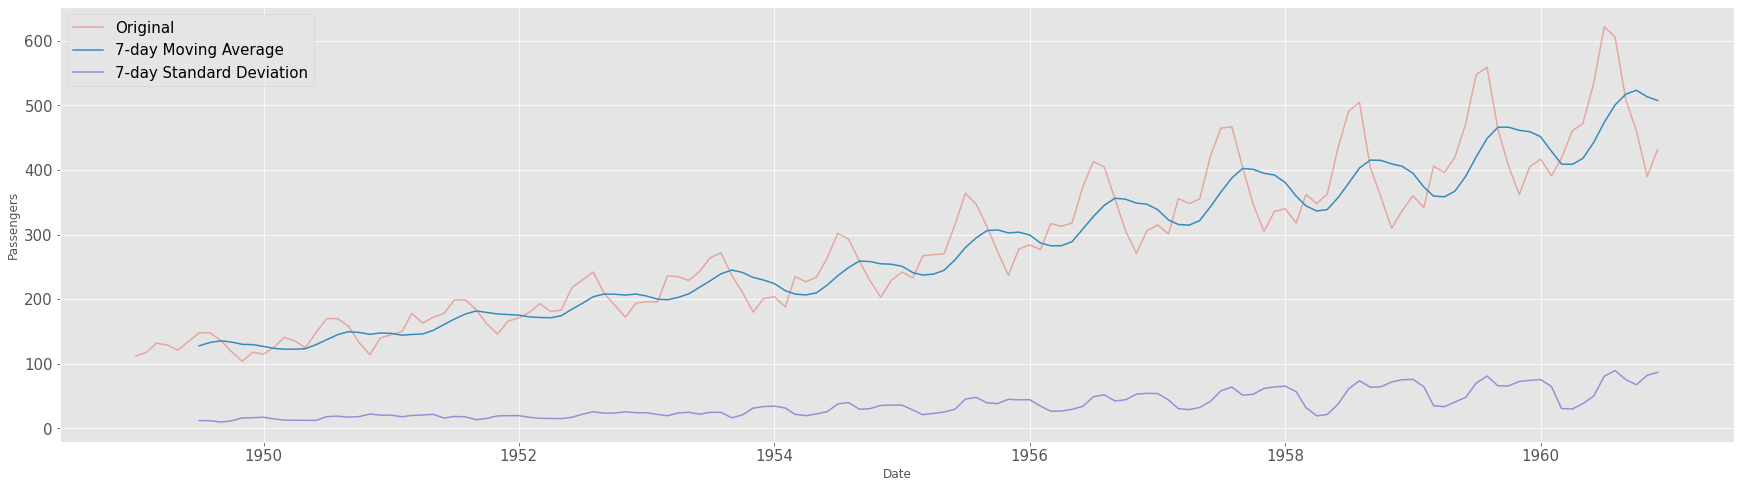

In [48]:
# Plotting Data
plt.figure(figsize=(30,8))

plt.plot(airline['Month'], airline['Passengers'], label='Original', alpha=0.4)
plt.plot(airline['Month'], airline['7D_MA'], label='7-day Moving Average')
plt.plot(airline['Month'], airline['7D_STD'], label='7-day Standard Deviation')

plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Date')
plt.ylabel('Passengers');

### Perform the time series decompose on the airline data

In [49]:
# your code here
decompose_sample = airline.copy() 

decompose_sample = decompose_sample.groupby(pd.Grouper(key='Month', freq='MS'))['Passengers'].mean().reset_index()

decompose_sample = decompose_sample.set_index(pd.to_datetime(decompose_sample['Month'])).dropna() 

decompose_sample.sort_index(inplace=True)


In [50]:
decompose_sample['Year'] = decompose_sample['Month'].dt.year # extracting the year and month from the dt objects
decompose_sample['Month'] = decompose_sample['Month'].dt.month

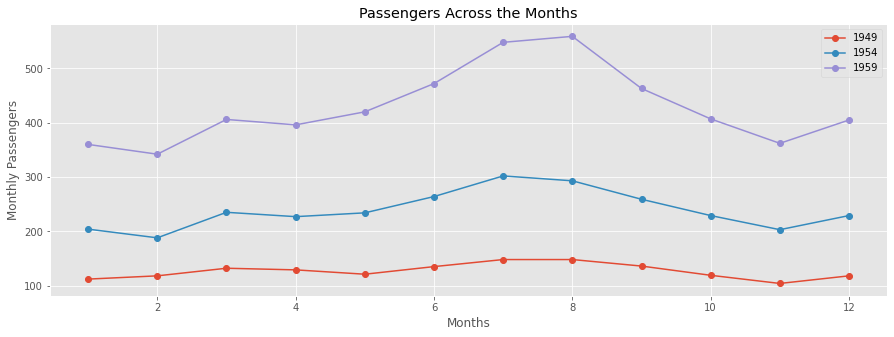

In [51]:
plt.figure(figsize=(15, 5))
for each in decompose_sample['Year'].unique()[0::5]:
    plt.plot(decompose_sample[decompose_sample['Year'] == each]['Month'],
             decompose_sample[decompose_sample['Year'] == each]['Passengers'], marker='o', label=each)
    
    plt.legend(loc='best')
    plt.xlabel('Months')
    plt.ylabel('Monthly Passengers')
    plt.title('Passengers Across the Months')

In [52]:
result = seasonal_decompose(decompose_sample['Passengers'], model='additive')

plotting the extracting features

Text(0.5, 1.0, 'Residuals')

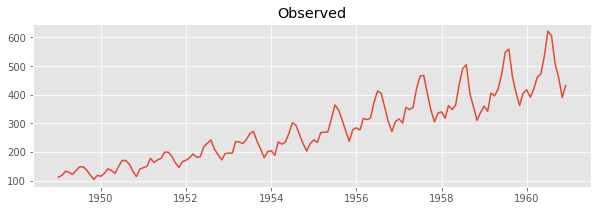

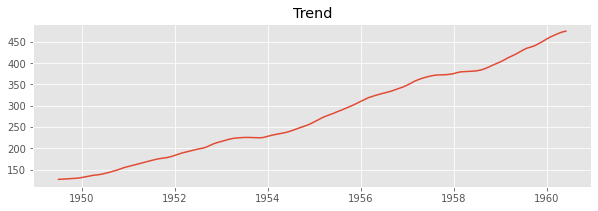

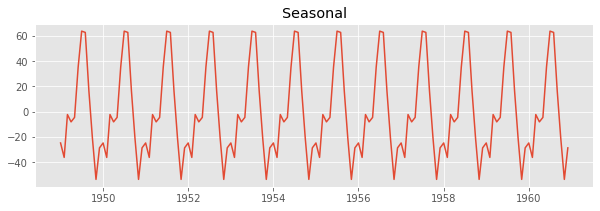

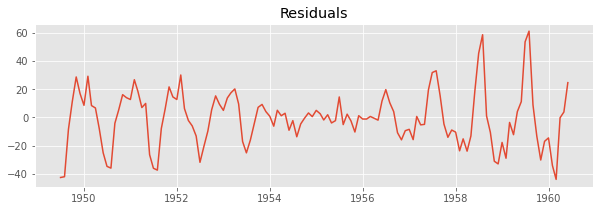

In [53]:
plt.figure(figsize=(10,3))
plt.plot(result.observed) # extracting observed results 
plt.title("Observed")

plt.figure(figsize=(10,3))
plt.plot(result.trend)
plt.title("Trend")

plt.figure(figsize=(10,3))
plt.plot(result.seasonal) # extracting seasonal 
plt.title("Seasonal")

plt.figure(figsize=(10,3))
plt.plot(result.resid) # extracting residuals
plt.title("Residuals") 

### Perform the ADFuller test on the airline data

In [54]:
result = adfuller(airline['Passengers'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


In [55]:
airline['Differenced First Order'] = airline['Passengers'].diff()

result = adfuller(airline['Differenced First Order'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.829267
p-value: 0.054213
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


### What is your conclusion? Is the time series stationary or not stationary?

The time series is not stationery! Computing the ADF statistic and p-values for the differenced and non-differenced values yielded a p-value of > 0.05. This means that we can safely accept the null hyptothesis, and accept that the data is not stationery. This lines up with the intuition provided by the graphs, which shows that the mean number of passengers increases over time. 